# LGM Virtual Internship Program

## Task 1: ML Facial Recognition to detect mood and suggest songs accordingly

## More Advanced Level Project

## Dataset : https://www.kaggle.com/msambare/fer2013

# Name : Amaan Ali

# ----------------------------------------------------------------------------------------------------------------

### First importing the required libraries

In [5]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [6]:
train_dir = 'train/'
test_dir = 'test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


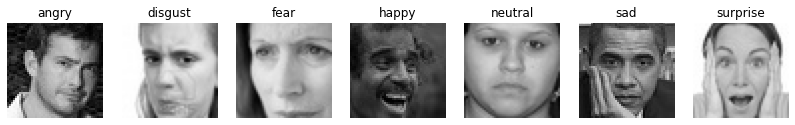

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

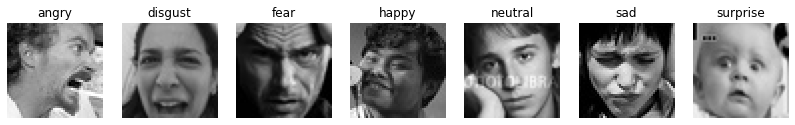

In [8]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(test_dir):
    img = load_img((test_dir + expression +'/'+ os.listdir(test_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

<AxesSubplot:>

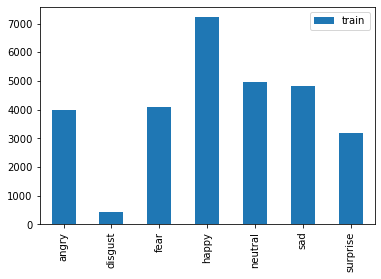

In [9]:
train_count.transpose().plot(kind='bar')

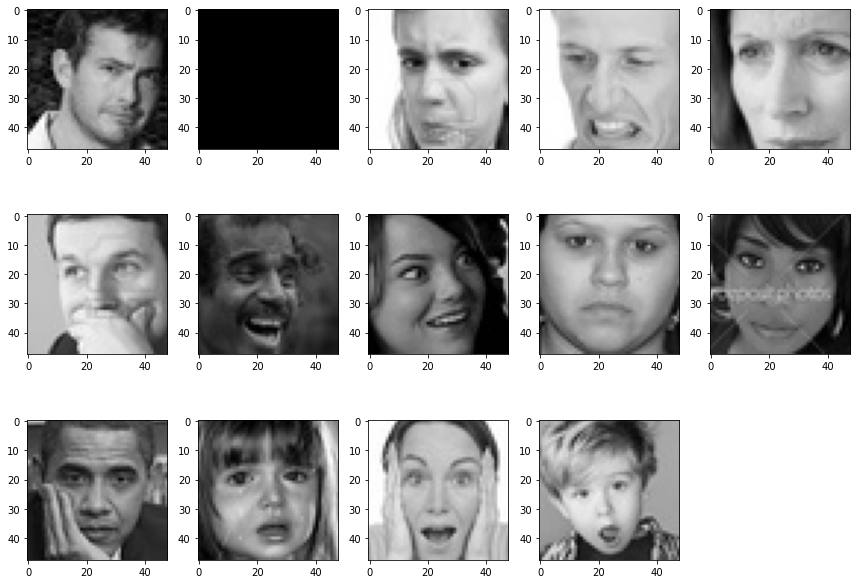

In [10]:
img_size = 48
plt.figure(0, figsize=(12,20))
index = 0
for link in os.listdir("train/"):
    for i in range(1,3):
        index += 1
        plt.subplot(7,5,index)
        img = load_img("train/" + link + "/" +os.listdir("train/" + link)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()

<AxesSubplot:>

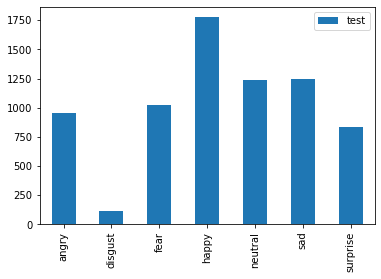

In [11]:
test_count.transpose().plot(kind='bar')

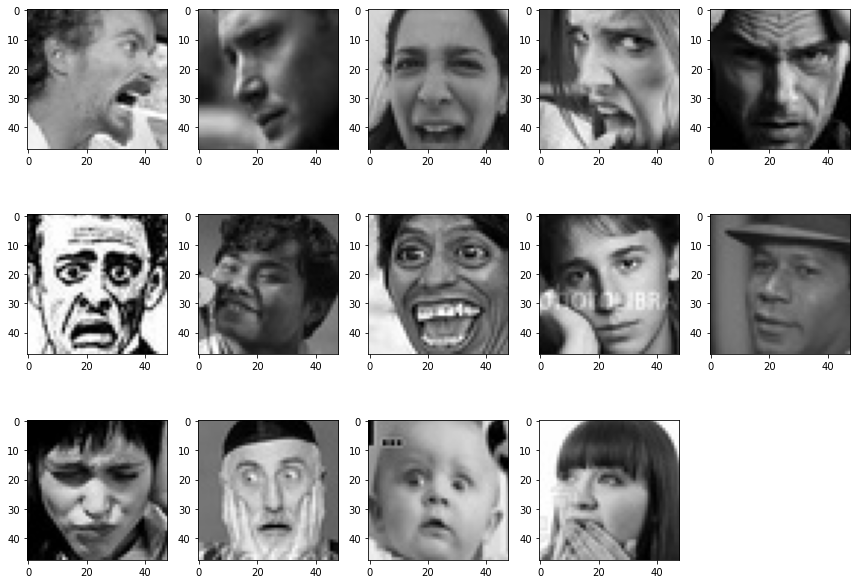

In [12]:
img_size = 48
plt.figure(0, figsize=(12,20))
index = 0
for link in os.listdir("test/"):
    for i in range(1,3):
        index += 1
        plt.subplot(7,5,index)
        img = load_img("test/" + link + "/" +os.listdir("test/" + link)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [15]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [16]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

In [17]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [18]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set, validation_data=test_set,epochs=2,callbacks=callbacks,steps_per_epoch=steps_per_epoch,validation_steps=validation_steps)

Epoch 1/2
448/448 [==============================] - 609s 1s/step - loss: 4.3328 - accuracy: 0.2702 - val_loss: 9.1689 - val_accuracy: 0.0843

Epoch 00001: val_loss improved from inf to 9.16885, saving model to ferNet.h5
Epoch 2/2
448/448 [==============================] - 492s 1s/step - loss: 3.5278 - accuracy: 0.3282 - val_loss: 3.1684 - val_accuracy: 0.3835

Epoch 00002: val_loss improved from 9.16885 to 3.16841, saving model to ferNet.h5


Confusion Matrix
[[ 316    0  168 2049  637  231  594]
 [  30    0   15  235   60   30   66]
 [ 367    0  175 2076  648  264  567]
 [ 619    0  320 3703 1077  486 1010]
 [ 463    0  208 2556  732  308  698]
 [ 413    0  210 2477  750  274  706]
 [ 266    0  140 1636  447  218  464]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.08      0.10      3995
     disgust       1.00      0.00      0.00       436
        fear       0.14      0.04      0.07      4097
       happy       0.25      0.51      0.34      7215
     neutral       0.17      0.15      0.16      4965
         sad       0.15      0.06      0.08      4830
    surprise       0.11      0.15      0.13      3171

    accuracy                           0.20     28709
   macro avg       0.28      0.14      0.12     28709
weighted avg       0.18      0.20      0.16     28709



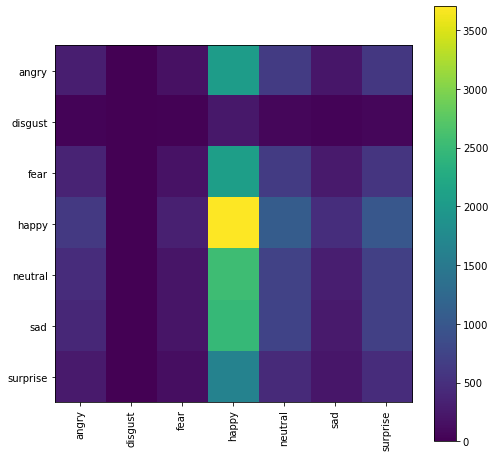

In [19]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, zero_division=1, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)